In [1]:
# Basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# xml library for parsing xml files
from xml.etree import ElementTree as et

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.utils import draw_bounding_boxes

# these are the helper libraries imported.
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from tqdm import tqdm # progress bar
import math
import sys

In [2]:
os.environ["CUDA_LAUNCH_BLOCKING"]="1"

In [3]:


# defining the files directory and testing directory
files_dir = './__train'
test_dir = './test'


class MalariaImagesDataset(torch.utils.data.Dataset):

    def __init__(self, files_dir, width, height, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        self.height = height
        self.width = width
        
        # sorting the images for consistency
        # To get images, the extension of the filename is checked to be jpg
        self.imgs = [image for image in sorted(os.listdir(files_dir))
                        if image[-4:]=='.png']
        
        
        # classes: 0 index is reserved for background
        self.classes = ['background', 'Esch','LT','LR-ET', 'Lsch', 'R', 'Seg', 'MT', 'DEBRIS', 'WBC']

    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name)

        # reading the images and converting them to correct size and color    
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # diving by 255
        img_res /= 255.0
        
        # annotation file
        annot_filename = img_name[:-4] + '.xml'
        annot_file_path = os.path.join(self.files_dir, annot_filename)
        
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        # cv2 image gives size as height x width
        wt = img.shape[1]
        ht = img.shape[0]
        
        # box coordinates for xml files are extracted and corrected for image size given
        for member in root.findall('object'):
            labels.append(self.classes.index(member.find('name').text))
            
            # bounding box
            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)
            
            
            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height
            
            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        
        # convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # getting the areas of the boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        # image_id
        image_id = torch.tensor([idx])
        target["image_id"] = image_id


        if self.transforms:
            
            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)
            
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
            
            
        return img_res, target

    def __len__(self):
        return len(self.imgs)

In [4]:
# check dataset
dataset = MalariaImagesDataset(files_dir, 224, 224) #224, 224 before
print('length of dataset = ', len(dataset), '\n')

# getting the image and target for a test index.  Feel free to change the index.
img, target = dataset[2]
print(img.shape, '\n',target)

length of dataset =  214 

(224, 224, 3) 
 {'boxes': tensor([[ 22.6918, 184.6369,  30.1476, 200.5126],
        [153.9797, 122.8738, 160.4631, 130.7029],
        [204.8741, 143.0990, 218.9754, 158.3223]]), 'labels': tensor([3, 3, 1]), 'area': tensor([118.3672,  50.7591, 214.6683]), 'iscrowd': tensor([0, 0, 0]), 'image_id': tensor([2])}


## Visualization

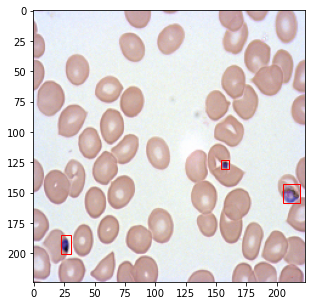

In [5]:
# Function to visualize bounding boxes in the image

def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 1,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()
    
# plotting the image with bboxes. Feel free to change the index
img, target = dataset[2]
plot_img_bbox(img, target)

## Model

In [6]:
def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    # model = torchvision.models.detection.fasterrcnn_resnet50_fpn()
    model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn()
    # model = torchvision.models.vgg16(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

## Augmentations

In [7]:
# Send train=True fro training transforms and False for val/test transforms
def get_transform(train):
    if train:
        return A.Compose([
                            A.HorizontalFlip(p=0.3),
                            A.VerticalFlip(p=0.3),
                            A.RandomBrightnessContrast(p=0.1),
                            A.ColorJitter(p=0.1),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2() 
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2()
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

## Preparing dataset

In [8]:
# use our dataset and defined transformations
dataset = MalariaImagesDataset(files_dir, 224, 224, transforms= get_transform(train=True))
dataset_test = MalariaImagesDataset(test_dir, 224, 224, transforms= get_transform(train=False))
# 580
# split the dataset in train and test set
# torch.manual_seed(1)
# indices = torch.randperm(len(dataset)).tolist()

# # train test split
# test_split = 0.2
# tsize = int(len(dataset)*test_split)
# dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
# dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=2, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)



## Training

In [9]:
# to train on gpu if selected.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 10

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0001, momentum=0.9, nesterov=True, weight_decay=1e-4)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [10]:
# training for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/107]  eta: 0:10:38  lr: 0.000001  loss: 3.0196 (3.0196)  loss_classifier: 2.2893 (2.2893)  loss_box_reg: 0.0054 (0.0054)  loss_objectness: 0.6905 (0.6905)  loss_rpn_box_reg: 0.0344 (0.0344)  time: 5.9690  data: 0.1110  max mem: 559
Epoch: [0]  [ 10/107]  eta: 0:01:14  lr: 0.000010  loss: 3.0242 (3.0322)  loss_classifier: 2.2911 (2.2899)  loss_box_reg: 0.0136 (0.0178)  loss_objectness: 0.6925 (0.6924)  loss_rpn_box_reg: 0.0344 (0.0321)  time: 0.7673  data: 0.0955  max mem: 698
Epoch: [0]  [ 20/107]  eta: 0:00:45  lr: 0.000020  loss: 3.0037 (3.0091)  loss_classifier: 2.2789 (2.2754)  loss_box_reg: 0.0124 (0.0155)  loss_objectness: 0.6922 (0.6922)  loss_rpn_box_reg: 0.0194 (0.0259)  time: 0.2473  data: 0.0930  max mem: 698
Epoch: [0]  [ 30/107]  eta: 0:00:33  lr: 0.000029  loss: 2.9542 (2.9779)  loss_classifier: 2.2248 (2.2450)  loss_box_reg: 0.0089 (0.0149)  loss_objectness: 0.6919 (0.6923)  loss_rpn_box_reg: 0.0212 (0.0257)  time: 0.2486  data: 0.0923  max mem: 698
Epoc

Epoch: [2]  [  0/107]  eta: 0:00:28  lr: 0.000100  loss: 0.9332 (0.9332)  loss_classifier: 0.2797 (0.2797)  loss_box_reg: 0.0861 (0.0861)  loss_objectness: 0.5269 (0.5269)  loss_rpn_box_reg: 0.0405 (0.0405)  time: 0.2700  data: 0.0800  max mem: 698
Epoch: [2]  [ 10/107]  eta: 0:00:22  lr: 0.000100  loss: 0.6760 (0.6814)  loss_classifier: 0.1055 (0.1108)  loss_box_reg: 0.0282 (0.0270)  loss_objectness: 0.5155 (0.5185)  loss_rpn_box_reg: 0.0236 (0.0251)  time: 0.2365  data: 0.0777  max mem: 698
Epoch: [2]  [ 20/107]  eta: 0:00:19  lr: 0.000100  loss: 0.6361 (0.6671)  loss_classifier: 0.0948 (0.1095)  loss_box_reg: 0.0183 (0.0258)  loss_objectness: 0.5091 (0.5060)  loss_rpn_box_reg: 0.0212 (0.0259)  time: 0.2257  data: 0.0772  max mem: 698
Epoch: [2]  [ 30/107]  eta: 0:00:17  lr: 0.000100  loss: 0.6312 (0.6604)  loss_classifier: 0.0949 (0.1121)  loss_box_reg: 0.0183 (0.0280)  loss_objectness: 0.4748 (0.4935)  loss_rpn_box_reg: 0.0218 (0.0268)  time: 0.2215  data: 0.0769  max mem: 698
Epoc

Epoch: [4]  [  0/107]  eta: 0:00:27  lr: 0.000010  loss: 0.4385 (0.4385)  loss_classifier: 0.1677 (0.1677)  loss_box_reg: 0.0513 (0.0513)  loss_objectness: 0.1833 (0.1833)  loss_rpn_box_reg: 0.0362 (0.0362)  time: 0.2560  data: 0.0820  max mem: 698
Epoch: [4]  [ 10/107]  eta: 0:00:23  lr: 0.000010  loss: 0.3468 (0.3458)  loss_classifier: 0.1166 (0.1238)  loss_box_reg: 0.0427 (0.0411)  loss_objectness: 0.1575 (0.1527)  loss_rpn_box_reg: 0.0294 (0.0283)  time: 0.2394  data: 0.0799  max mem: 698
Epoch: [4]  [ 20/107]  eta: 0:00:20  lr: 0.000010  loss: 0.2976 (0.3222)  loss_classifier: 0.0920 (0.1133)  loss_box_reg: 0.0315 (0.0373)  loss_objectness: 0.1454 (0.1460)  loss_rpn_box_reg: 0.0229 (0.0256)  time: 0.2307  data: 0.0786  max mem: 698
Epoch: [4]  [ 30/107]  eta: 0:00:17  lr: 0.000010  loss: 0.2860 (0.3289)  loss_classifier: 0.0823 (0.1149)  loss_box_reg: 0.0219 (0.0369)  loss_objectness: 0.1399 (0.1479)  loss_rpn_box_reg: 0.0227 (0.0291)  time: 0.2246  data: 0.0779  max mem: 698
Epoc

Epoch: [6]  [  0/107]  eta: 0:00:28  lr: 0.000001  loss: 0.3175 (0.3175)  loss_classifier: 0.1189 (0.1189)  loss_box_reg: 0.0298 (0.0298)  loss_objectness: 0.1431 (0.1431)  loss_rpn_box_reg: 0.0257 (0.0257)  time: 0.2660  data: 0.0800  max mem: 698
Epoch: [6]  [ 10/107]  eta: 0:00:23  lr: 0.000001  loss: 0.2921 (0.3508)  loss_classifier: 0.1034 (0.1247)  loss_box_reg: 0.0383 (0.0482)  loss_objectness: 0.1316 (0.1432)  loss_rpn_box_reg: 0.0308 (0.0348)  time: 0.2385  data: 0.0791  max mem: 698
Epoch: [6]  [ 20/107]  eta: 0:00:20  lr: 0.000001  loss: 0.2921 (0.3312)  loss_classifier: 0.1034 (0.1183)  loss_box_reg: 0.0383 (0.0430)  loss_objectness: 0.1305 (0.1396)  loss_rpn_box_reg: 0.0267 (0.0304)  time: 0.2326  data: 0.0791  max mem: 698
Epoch: [6]  [ 30/107]  eta: 0:00:17  lr: 0.000001  loss: 0.3281 (0.3335)  loss_classifier: 0.1157 (0.1213)  loss_box_reg: 0.0373 (0.0435)  loss_objectness: 0.1305 (0.1385)  loss_rpn_box_reg: 0.0263 (0.0303)  time: 0.2293  data: 0.0797  max mem: 698
Epoc

Epoch: [8]  [  0/107]  eta: 0:00:29  lr: 0.000001  loss: 0.2912 (0.2912)  loss_classifier: 0.0748 (0.0748)  loss_box_reg: 0.0199 (0.0199)  loss_objectness: 0.1335 (0.1335)  loss_rpn_box_reg: 0.0630 (0.0630)  time: 0.2790  data: 0.0820  max mem: 698
Epoch: [8]  [ 10/107]  eta: 0:00:22  lr: 0.000001  loss: 0.2912 (0.3462)  loss_classifier: 0.1107 (0.1270)  loss_box_reg: 0.0339 (0.0473)  loss_objectness: 0.1330 (0.1403)  loss_rpn_box_reg: 0.0296 (0.0317)  time: 0.2354  data: 0.0798  max mem: 698
Epoch: [8]  [ 20/107]  eta: 0:00:19  lr: 0.000001  loss: 0.3431 (0.3642)  loss_classifier: 0.1306 (0.1343)  loss_box_reg: 0.0379 (0.0512)  loss_objectness: 0.1425 (0.1453)  loss_rpn_box_reg: 0.0306 (0.0334)  time: 0.2261  data: 0.0792  max mem: 698
Epoch: [8]  [ 30/107]  eta: 0:00:17  lr: 0.000001  loss: 0.3431 (0.3296)  loss_classifier: 0.1306 (0.1188)  loss_box_reg: 0.0373 (0.0432)  loss_objectness: 0.1315 (0.1378)  loss_rpn_box_reg: 0.0252 (0.0299)  time: 0.2227  data: 0.0789  max mem: 698
Epoc

In [ ]:
model.eval()
torch.cuda.empty_cache()

In [ ]:
img, target = dataset_test[1]


img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]
    print(pred['scores'])

In [ ]:
classes = ['background', 'Esch','LT','LR-ET', 'Lsch', 'R', 'Seg', 'MT', 'DEBRIS']

fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.408],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.408].tolist()], width=1
).permute(1, 2, 0))

In [ ]:
os.listdir(test_dir)